In [1]:
import sys
sys.path.append("../")

from hybri import Hybrizone, HybriParams, PolarPoint, AirData, AngleMode, CoordMode, BuildMode, CurveMode, InterpolationDomain, SmoothedConvolution
import librosa as lb
import numpy as np
import pyaudio as pa
import time
import matplotlib.pyplot as plt
# import time 
# from collections import deque
# import scipy
# from threading import Thread, Event
# from queue import Queue
# import hashlib

# from concurrent.futures import ThreadPoolExecutor
# from numpy.typing import NDArray


In [2]:

HRIR_PATH = "/Users/pm/AcaHub/Coding/BinauralSpatial/data/HRIR-KEMAR_DATASET.h5"
RIR_PATH = "/Users/pm/AcaHub/Coding/BinauralSpatial/data/RIR-MIT_SURVEY.h5"
AUDIO_PATH = "/Users/pm/AcaHub/AudioSamples/suzanne_mono.wav"

CHUNK = 1024
SR = 44100
CHANNELS = 2

PARAMS = HybriParams(
        hrir_database=HRIR_PATH, 
        rir_database=RIR_PATH, 
        coord_mode=CoordMode.REGULAR, 
        interp_domain=InterpolationDomain.FREQUENCY,
        build_mode=BuildMode.LINEAR,
        chunk_size=CHUNK,
        interpolation_neighs=3
)

SIG, _ = lb.load(AUDIO_PATH, sr=SR)
SIG_LIMIT = len(SIG)

In [3]:
h = Hybrizone(params=PARAMS)

air_conditions = AirData(temperature=20, humidity=0.5, pressure=101325.0)
h.imposed_air_conditions(air_data=air_conditions)
h.set_rirs(rir1=1, rir2=90, smooth_factor=0.1)

In [ ]:
h.start_space_data_process()

p = pa.PyAudio()
stream = p.open(format=pa.paFloat32, channels=2, rate=SR, output=True, frames_per_buffer=CHUNK)
stream.start_stream()

mark = 0
while True:
    
    if mark >= SIG_LIMIT:
        h.close()
        break
    
    end = min(mark + CHUNK, SIG_LIMIT - 1)
    frame = SIG[mark:end]
    
    pos = PolarPoint(rho=1.7, phi=20, theta=60, opt=AngleMode.DEGREE)
    h.set_position(position=pos)
    h.set_morph_data(direction=0.5, morph_curve=CurveMode.SIGMOID)
    
    kernels = h.get_rir_and_hrir()
    if kernels is not None:
        convolved_frame = h.process_frame(frame=frame, kernels=kernels)
        stream.write(convolved_frame.tobytes())
        
        mark += CHUNK
    else:
        stream.write(np.zeros((CHUNK, 2), dtype=np.float32).tobytes())
        
while True:
    try:
        pass
    except KeyboardInterrupt:
        print("[INFO] Process blocked by user!")
        break

stream.stop_stream()
stream.close()
p.terminate()

In [4]:
h.start_space_data_process()
pos = PolarPoint(rho=20, phi=10, theta=60, opt=AngleMode.DEGREE)
h.set_position(position=pos)
h.set_morph_data(direction=0.5, morph_curve=CurveMode.SIGMOID)
kernels = h.get_rir_and_hrir()
print(kernels)
# h.close()


[INFO] SPACE PROCESS STARTED!
[WARNING] Empty cache!
[WARNING] Searching pos...


In [15]:
kernels.hrir

array([[-9.97015323e-07, -2.45009160e-10],
       [ 1.17748644e-07,  3.68721266e-09],
       [-8.21179220e-08, -4.26366593e-09],
       ...,
       [-7.36341588e-05, -3.27207838e-06],
       [-7.64248829e-05, -1.20739442e-06],
       [-9.64190651e-05,  3.72388343e-07]])

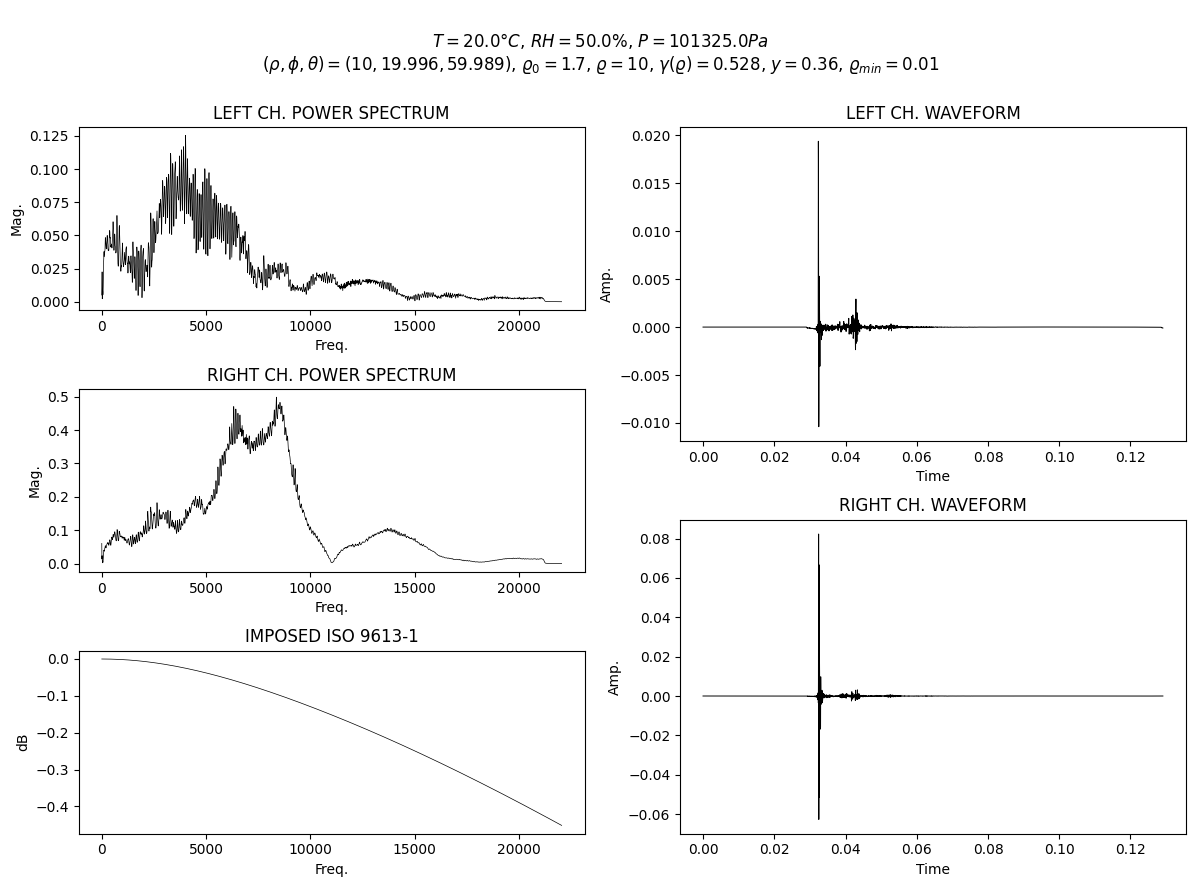

In [16]:
h.display_hrir(hrir=kernels.hrir, title="")

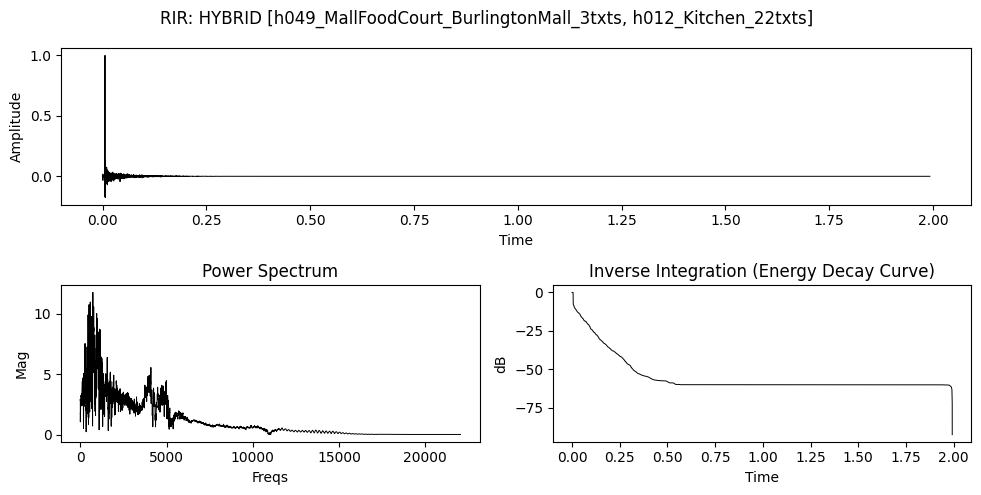

In [7]:
h.display_rir(rir=kernels.rir, title="HYBRID [h049_MallFoodCourt_BurlingtonMall_3txts, h012_Kitchen_22txts]")

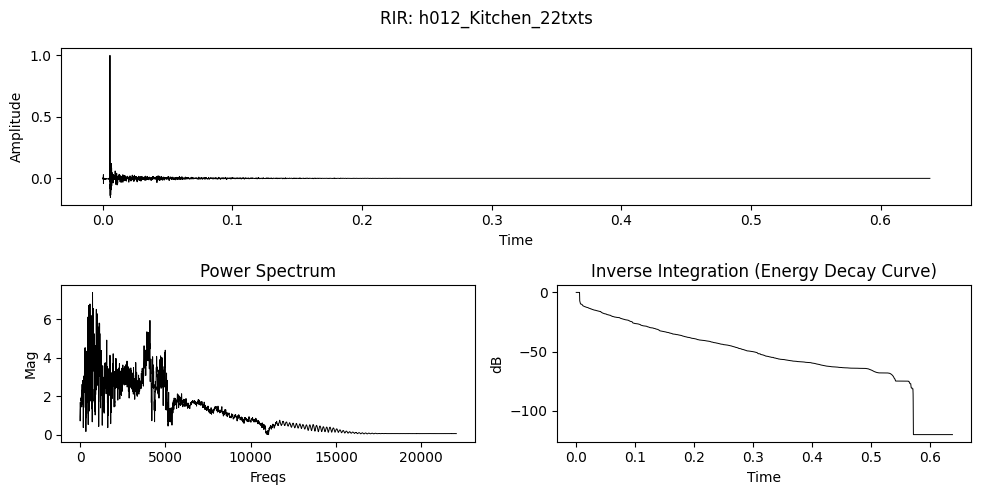

In [8]:
h.display_rir(rir=90)

In [9]:
h.get_rir_key(rir_index=1)

'h049_MallFoodCourt_BurlingtonMall_3txts'

In [10]:
h.get_rir_key(rir_index=90)

'h012_Kitchen_22txts'

In [2]:
# main scripts
HRIR_PATH = "/Users/pm/AcaHub/Coding/BinauralSpatial/data/HRIR-KEMAR_DATASET.h5"
RIR_PATH = "/Users/pm/AcaHub/Coding/BinauralSpatial/data/RIR-MIT_SURVEY.h5"
AUDIO_PATH = "/Users/pm/AcaHub/AudioSamples/suzanne_mono.wav"

CHUNK = 4096
SR = 44100
CHANNELS = 2

PARAMS = HybriParams(
        hrir_database_path=HRIR_PATH, 
        rir_database_path=None, 
        coord_mode=CoordMode.REGULAR, # TODO: interaural problema itd a 90 e 270 gradi
        interp_domain=InterpolationDomain.FREQUENCY,
        build_mode=BuildMode.SPHERICAL,
        chunk_size=CHUNK,
        interpolation_neighs=2
)
itds = []

In [23]:
# start hybri
AURALIZER = Hybrizone(params=PARAMS)

# set air conditions
air_conditions = AirData(temperature=20, humidity=50, pressure=101325.0)
AURALIZER.imposed_air_conditions(air_data=air_conditions)

current_phi = 0
current_theta = 0
current_rho = 0
dstep = 0.1

hrirs = []
itds_temp = []

distances = [1.7, 2.7, 5, 10, 15, 20]
gains = []

for d in distances:

    pos = PolarPoint(rho=d, phi=current_phi, theta=current_theta, opt=AngleMode.DEGREE) 
    AURALIZER.set_position(position=pos)
    
    # if current_theta >= 360: 
    #     break
    
    # generates kernels (HRIR and RIR)
    kernels = AURALIZER.get_kernels()
    if kernels is not None:
        hrirs.append(kernels.hrir)
        itds_temp.append(kernels.itd)
        gains.append(kernels.gain)
        # current_theta += dstep
        
    time.sleep(1 / SR)

gains = np.array(gains)
# itds.append(itds_temp)


# pos = PolarPoint(rho=2.7, phi=0.0, theta=0.0, opt=AngleMode.DEGREE) 
# AURALIZER.set_position(position=pos)
# # generates kernels (HRIR and RIR)
# kernels = AURALIZER.get_kernels()
# AURALIZER.display_hrir(hrir=kernels.hrir, title="")
AURALIZER.close()


[INFO] Close Hybrizone...
[INFO] Free memory
[INFO] Hybrizone closed!


In [4]:
degree = np.linspace(0, 360, num=len(itds[0]))
degree = np.radians(degree)
itds = np.array(itds)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)
 
ax.plot(degree, itds[0], c="k", lw=0.7, label=r"$\varrho = 1.7$m")
ax.plot(degree, itds[1], c="r", lw=0.7, label=r"$\varrho = 0.5$m")

ax.set_theta_direction(1)  # senso orario
ax.set_theta_zero_location('N')  # 0° in alto
ax.grid(alpha=0.7)
ax.legend(loc='upper left', bbox_to_anchor=(0.9, 1.1), borderaxespad=0.)

 
plt.show()

IndexError: list index out of range

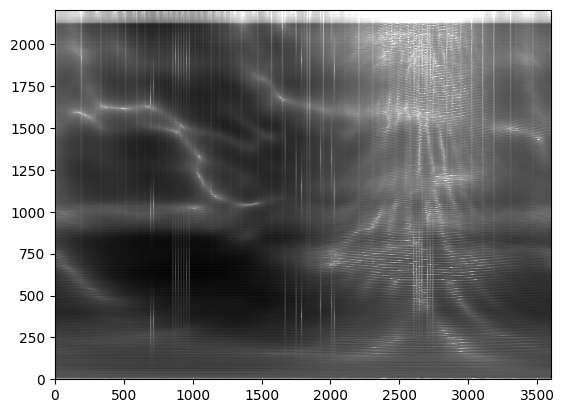

In [7]:
h = np.array(hrirs, dtype=np.float64)
left = h[:, :, 0]
right = h[:, :, 1]
left.shape

lfft = np.fft.rfft(left, axis=1)
rfft = np.fft.rfft(right, axis=1)

plt.pcolormesh(lb.amplitude_to_db(np.abs(rfft.T)), cmap="gray_r")
plt.show()

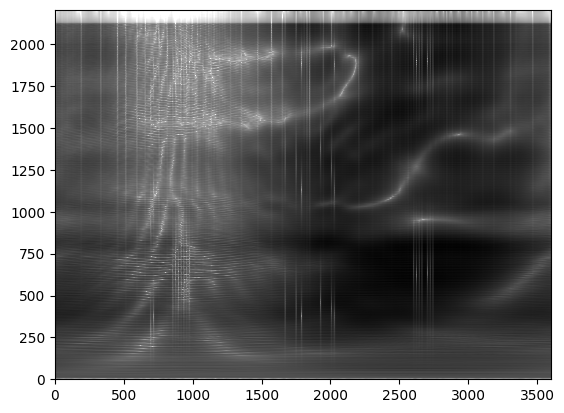

In [8]:
plt.pcolormesh(lb.amplitude_to_db(np.abs(lfft.T)), cmap="gray_r")
plt.show()

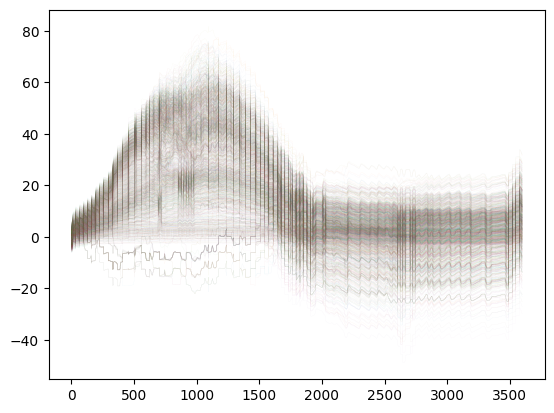

In [19]:
plt.plot(np.unwrap(np.angle(lfft), axis=0), lw=0.01)
plt.show()

AttributeError: 'NoneType' object has no attribute 'rho'

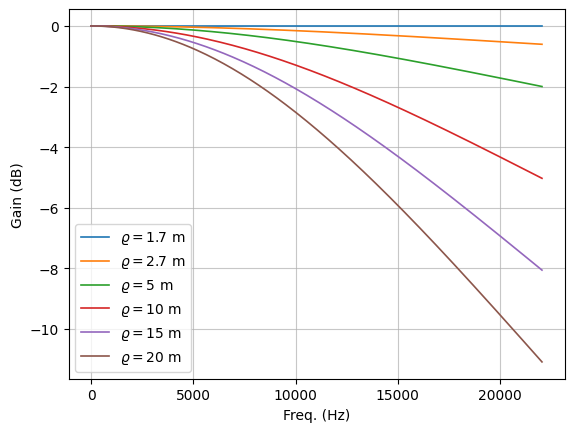

In [35]:
f = np.linspace(0, 22050, num=gains.shape[1])
plt.plot(f, gains[0], lw=1.2, label=r'$\varrho =$' f'{distances[0]} m')
plt.plot(f, gains[1], lw=1.2, label=r'$\varrho =$' f'{distances[1]} m')
plt.plot(f, gains[2], lw=1.2, label=r'$\varrho =$' f'{distances[2]} m')
plt.plot(f, gains[3], lw=1.2, label=r'$\varrho =$' f'{distances[3]} m')
plt.plot(f, gains[4], lw=1.2, label=r'$\varrho =$' f'{distances[4]} m')
plt.plot(f, gains[5], lw=1.2, label=r'$\varrho =$' f'{distances[5]} m')
plt.xlabel("Freq. (Hz)")
plt.ylabel("Gain (dB)")
plt.legend()
plt.grid(alpha=0.7)
plt.show()

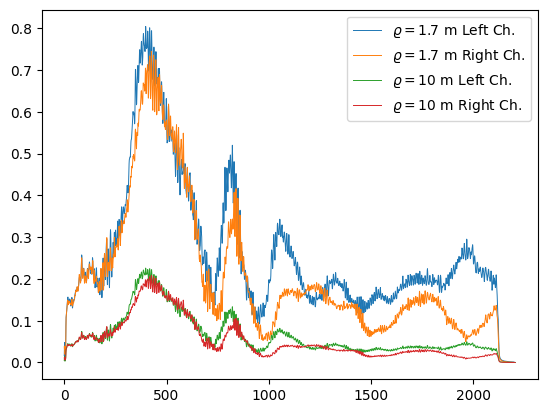

In [ ]:
freqs = np.fft.rfftfreq(n=hrirs[0].shape[0], d = 1 / 44100)
m1l = np.abs(np.fft.rfft(hrirs[0][:, 0]))
m1r = np.abs(np.fft.rfft(hrirs[0][:, 1]))
m2l = np.abs(np.fft.rfft(hrirs[3][:, 0]))
m2r = np.abs(np.fft.rfft(hrirs[3][:, 1]))
plt.plot(freqs, m1l, lw=0.7, label=r'$\varrho =$' f'{distances[0]} m' ' Left Ch.')
plt.plot(freqs, m1r, lw=0.7, label=r'$\varrho =$' f'{distances[0]} m' ' Right Ch.' )
plt.plot(freqs, m2l, lw=0.7, label=r'$\varrho =$' f'{distances[3]} m' ' Left Ch.')
plt.plot(freqs, m2r, lw=0.7, label=r'$\varrho =$' f'{distances[3]} m' ' Right Ch.')
plt.legend()
plt.show()